In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from playervectors import PlayerHeatMap
from ExtractData import ExtractCoordinates, ExtractPlayers, ExtractTeams, ExtractMinutesPlayed, ExtractGoalkeepers, CalcPlayingDirection, NormalizeDirection

## Load: Players

In [2]:
df_players = pd.read_csv('event_streams/players.csv')
df_players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,NaN,Konat\u00e9,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,NaN


#### Extract Player Information

In [3]:
# Mapping {playerID -> [list of selected attributes]}
players = ExtractPlayers(df=df_players, wy_id='wyId', attributes=['firstName', 'lastName', 'currentTeamId'])

In [4]:
df_playerank = pd.read_csv('event_streams/playerank.csv')
df_playerank.head()

,goalScored,playerankScore,matchId,playerId,roleCluster,minutesPlayed
0,0,0.0053,2057991,10014,right CB,90
1,0,0.0009,2057992,10014,right CB,41
2,0,-0.0013,2057998,100140,central MF,90
3,0,0.0031,2058000,100140,left CB,90
4,0,0.0035,2499869,10108,right CB,90


#### Extract Goalkeepers

In [5]:
keepers = ExtractGoalkeepers(df_players, wy_code='name', keeper_str='Goalkeeper')

#### Extract Played Minutes

In [6]:
# Extract played minutes
# Mapping {playerID -> minutes}
minutes_played = ExtractMinutesPlayed(df=df_playerank, column_player='playerId', column_minutes='minutesPlayed')

## Load: Event Streams

In [7]:
df_events = pd.read_csv('event_streams/actions.csv')
df_events.head()

,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name
0,0,2500089,1,2.763597,1659,9637,52.50,34.00,63.00,30.60,251700146.0,0,0,1,0,pass,success,foot
1,1,2500089,1,4.761353,1659,8351,63.00,30.60,64.05,10.20,251700147.0,0,0,1,1,pass,success,foot
2,2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,251700148.0,0,0,1,2,pass,success,foot
3,3,2500089,1,7.707561,1659,239411,72.45,20.40,35.70,19.04,251700161.0,0,0,1,3,pass,success,foot
4,4,2500089,1,11.614943,1659,9637,35.70,19.04,30.45,12.24,251700149.0,0,0,1,4,pass,success,foot


In [8]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462726 entries, 0 to 2462725
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   game_id            int64  
 2   period_id          int64  
 3   time_seconds       float64
 4   team_id            int64  
 5   player_id          int64  
 6   start_x            float64
 7   start_y            float64
 8   end_x              float64
 9   end_y              float64
 10  original_event_id  float64
 11  bodypart_id        int64  
 12  type_id            int64  
 13  result_id          int64  
 14  action_id          int64  
 15  type_name          object 
 16  result_name        object 
 17  bodypart_name      object 
dtypes: float64(6), int64(9), object(3)
memory usage: 338.2+ MB


In [9]:
df_events.describe()

,Unnamed: 0,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id
count,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.294126e+06,2.462726e+06,2.462726e+06,2.462726e+06,2.462726e+06
mean,1.231362e+06,2.495803e+06,1.496830e+00,1.382021e+03,2.990274e+03,8.725412e+04,5.484526e+01,3.390635e+01,4.753029e+01,3.382522e+01,2.157923e+08,1.425847e-01,3.774789e+00,8.160230e-01,6.387260e+02
std,7.109279e+05,1.579431e+05,5.064189e-01,8.320449e+02,2.898998e+03,1.155894e+05,2.542643e+01,2.014023e+01,2.543674e+01,2.017090e+01,3.017326e+07,4.812491e-01,6.830892e+00,3.950910e-01,3.746623e+02
min,0.000000e+00,1.694390e+06,1.000000e+00,0.000000e+00,6.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.817864e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.156812e+05,2.500090e+06,1.000000e+00,6.548361e+02,1.613000e+03,8.958000e+03,3.465000e+01,1.632000e+01,2.835000e+01,1.632000e+01,1.988792e+08,0.000000e+00,0.000000e+00,1.000000e+00,3.170000e+02
50%,1.231362e+06,2.516840e+06,1.000000e+00,1.364079e+03,2.460000e+03,2.553700e+04,5.670000e+01,3.400000e+01,4.515000e+01,3.400000e+01,2.190778e+08,0.000000e+00,0.000000e+00,1.000000e+00,6.340000e+02
75%,1.847044e+06,2.565832e+06,2.000000e+00,2.096673e+03,3.766000e+03,1.343990e+05,7.350000e+01,5.168000e+01,6.825000e+01,5.168000e+01,2.352287e+08,0.000000e+00,4.000000e+00,1.000000e+00,9.510000e+02
max,2.462725e+06,2.576338e+06,5.000000e+00,3.534783e+03,1.983000e+04,5.685830e+05,1.050000e+02,6.800000e+01,1.050000e+02,6.800000e+01,2.802175e+08,3.000000e+00,2.200000e+01,3.000000e+00,1.803000e+03


In [10]:
def CalcPlayingDirection(df: pd.DataFrame,
                         keepers: dict,
                         playerID_col: str = 'player_id',
                         matchID_col: str = 'game_id',
                         matchPeriod_col: str = 'period_id',
                         teamID_col: str = 'team_id',
                         cord_col: str = 'start_x') -> dict:
    directions = {} 

    for _, row in df.iterrows():
        playerID = row[playerID_col]
        matchID = row[matchID_col]
        matchPeriod = row[matchPeriod_col]
        teamID = row[teamID_col]
        cord = row[cord_col]

        # Check if the player is a goalkeeper
        if playerID in keepers:
            direction = 'ltr' if cord <= 50.0 else 'rtl'

            if matchID not in directions:
                directions[matchID] = {}

            if teamID not in directions[matchID]:
                directions[matchID][teamID] = {}

            if matchPeriod not in directions[matchID][teamID]:
                directions[matchID][teamID][matchPeriod] = {'ltr': 0, 'rtl': 0}

            directions[matchID][teamID][matchPeriod][direction] += 1

    return directions
directions = CalcPlayingDirection(df_events, keepers)
print(list(directions.items())[:10])

[(2500089, {1646: {1: {'ltr': 0, 'rtl': 23}, 2: {'ltr': 0, 'rtl': 18}}, 1659: {1: {'ltr': 0, 'rtl': 24}, 2: {'ltr': 0, 'rtl': 12}}}), (2500090, {1628: {1: {'ltr': 0, 'rtl': 17}, 2: {'ltr': 0, 'rtl': 12}}, 1627: {1: {'ltr': 2, 'rtl': 13}, 2: {'ltr': 0, 'rtl': 14}}}), (2500091, {1673: {1: {'ltr': 0, 'rtl': 20}, 2: {'ltr': 1, 'rtl': 16}}, 1609: {1: {'ltr': 0, 'rtl': 27}, 2: {'ltr': 0, 'rtl': 25}}}), (2500092, {1651: {1: {'ltr': 0, 'rtl': 27}, 2: {'ltr': 0, 'rtl': 17}}, 1612: {1: {'ltr': 0, 'rtl': 16}, 2: {'ltr': 0, 'rtl': 20}}}), (2500093, {1644: {1: {'ltr': 0, 'rtl': 15}, 2: {'ltr': 0, 'rtl': 19}}, 1611: {1: {'ltr': 0, 'rtl': 16}, 2: {'ltr': 0, 'rtl': 12}}}), (2500094, {1610: {1: {'ltr': 2, 'rtl': 22}, 2: {'ltr': 1, 'rtl': 12}}, 1613: {1: {'ltr': 0, 'rtl': 14}, 2: {'ltr': 0, 'rtl': 20}}}), (2500095, {1625: {1: {'ltr': 0, 'rtl': 25}, 2: {'ltr': 0, 'rtl': 15}}, 1619: {1: {'ltr': 0, 'rtl': 13}, 2: {'ltr': 1, 'rtl': 13}}}), (2500096, {1639: {1: {'ltr': 0, 'rtl': 35}, 2: {'ltr': 0, 'rtl': 33}

#### Normalize Playing Direction

In [11]:
df_events['start_x'] = 100 - df_events['start_x']
df_events['start_y'] = 100 - df_events['start_y']

#### Select Relevant Actions with respect to thier x,y coordinates

In [12]:
# {action -> {playerID -> ([list of x coordinates], [list of y coordinates])}}
coordinates = ExtractCoordinates(df=df_events, column_player_id='player_id', column_event_name='type_name', column_x='start_x', column_y='start_y', actions=['pass'])

## Load: Teams

In [13]:
df_teams = pd.read_csv('event_streams/teams.csv')
df_teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


#### Extract Team Information

In [14]:
# Extracting Team Information
# Mapping {teamID -> [selected attributes e.g. TeamName, City, ...]}
teams = ExtractTeams(df=df_teams, wy_id='wyId', attributes=['name'])

In [15]:
# Mapping {teamID -> [list of playerIDs]}
teamID_to_playerIDs = {}

# Mapping {playerID -> Player Name}
playersID_to_name = {}

for playerID, attributes in players.items():
    first, last, teamID = attributes[0], str(attributes[1]), str(attributes[2])
    
    if teamID not in teamID_to_playerIDs:
        teamID_to_playerIDs[teamID] = [playerID]
    else:
        teamID_to_playerIDs[teamID].append(playerID)
    
    if playerID not in playersID_to_name:
        playersID_to_name[playerID] = f'{first} {last}'

## Building HeatMaps

In [16]:
# ------------------------------------------------------
# Hyperparameters:
M, N = 50, 50               # Grid dimensions
sigma = 4.0                 # Sigma for gaussian blur
action = 'pass'             # Relevant action

playerID_to_heatmap = {}
for playerID, pairXY in list(coordinates[action].items()):
    x, y = pairXY[0], pairXY[1] 

    # Check for played minutes 
    minutes = 0.0 
    if playerID in minutes_played: 
        minutes = minutes_played[playerID] 

    # Check for player name
    player_name = None
    if playerID in playersID_to_name:
        player_name = playersID_to_name[playerID]

    # Build Player-Vectors
    heatmap = PlayerHeatMap(shape=(M, N),
                            player_name=player_name,
                            player_id=playerID,
                            action_name=action,
                            sigma=sigma,
                            map_size=[[0, 100], [0, 100]])
    
    # 1 - 3: Counting + Normalizing + Smoothing
    heatmap.fit(x, y, minutes)

    # 4: TODO: Create matrix M of all reshaped heatmaps and use NMF
    
    playerID_to_heatmap[playerID] = heatmap

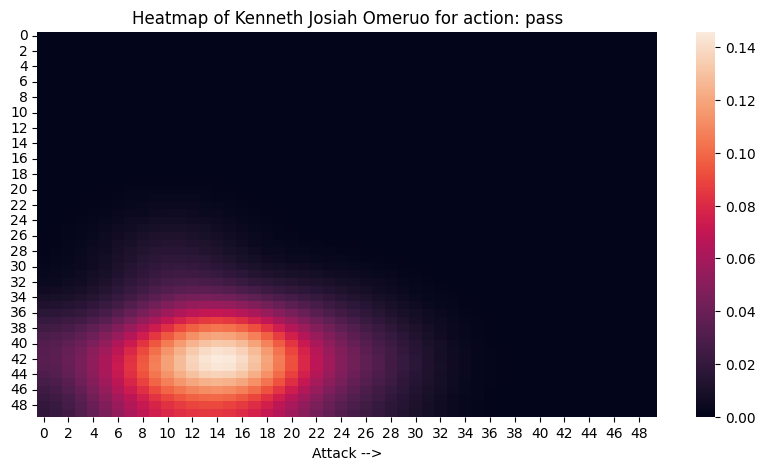

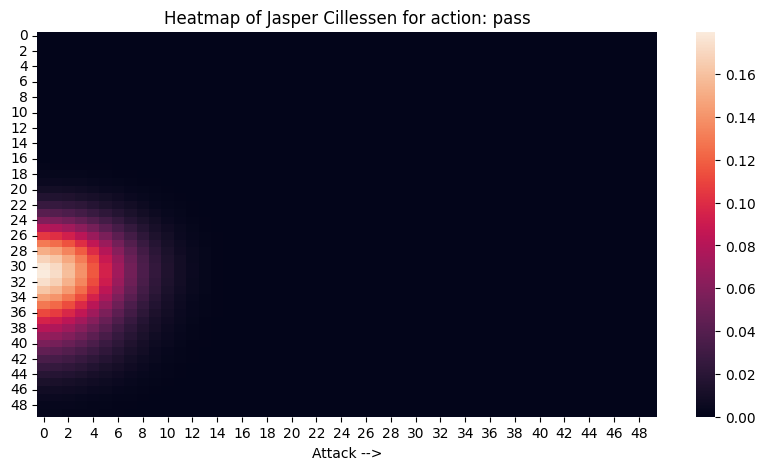

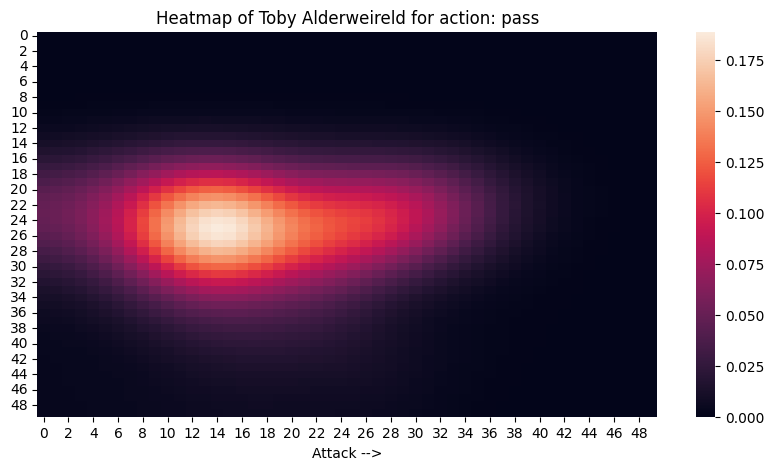

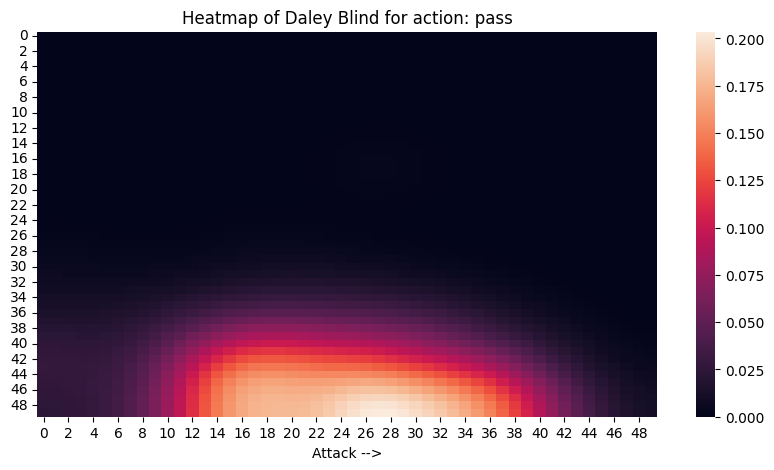

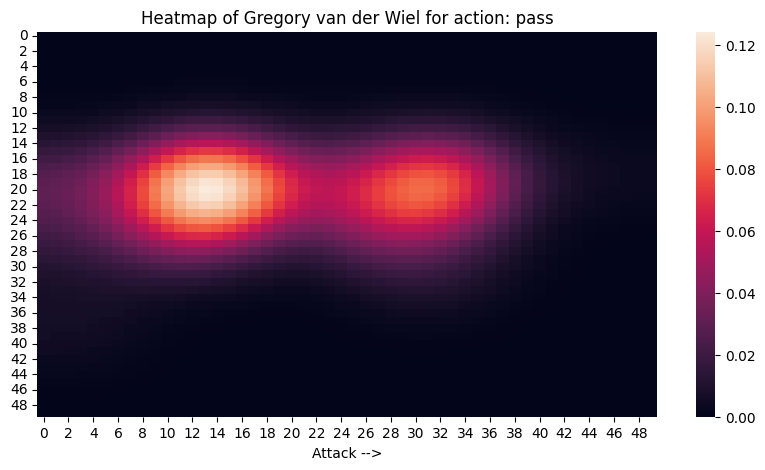

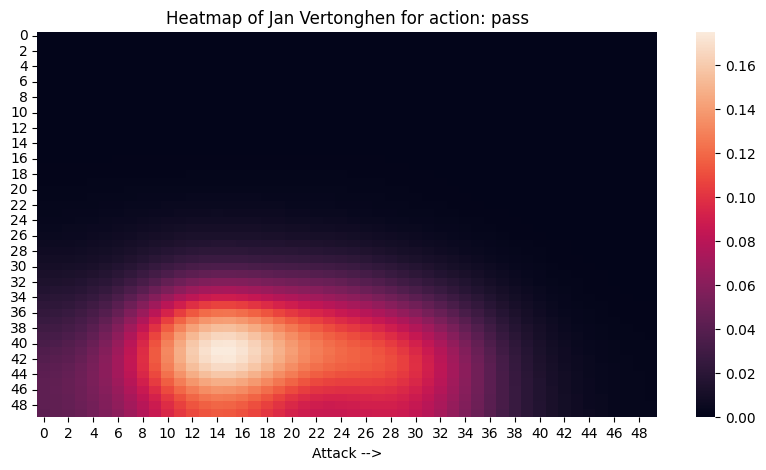

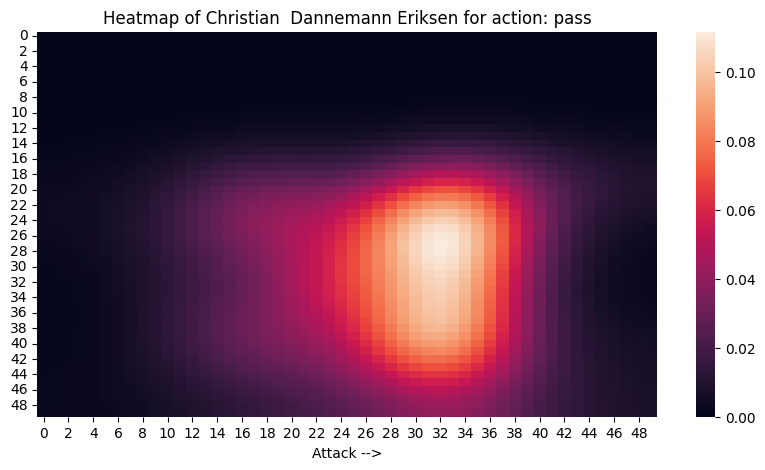

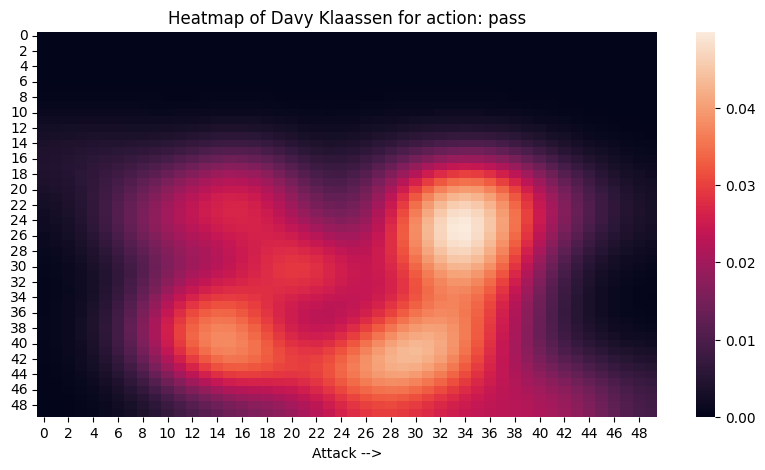

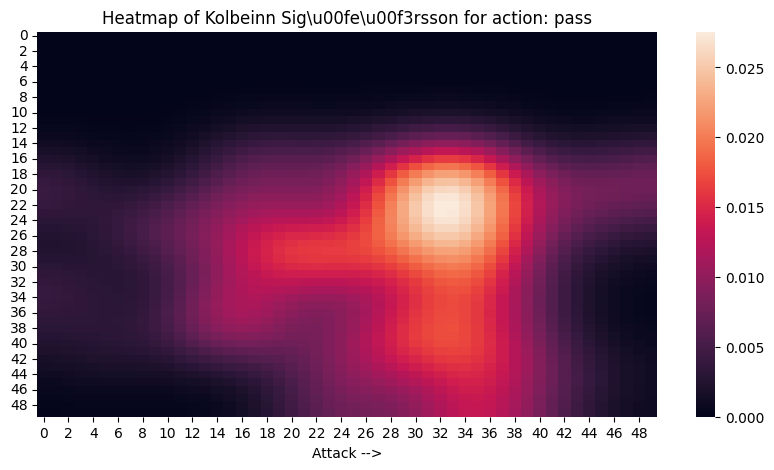

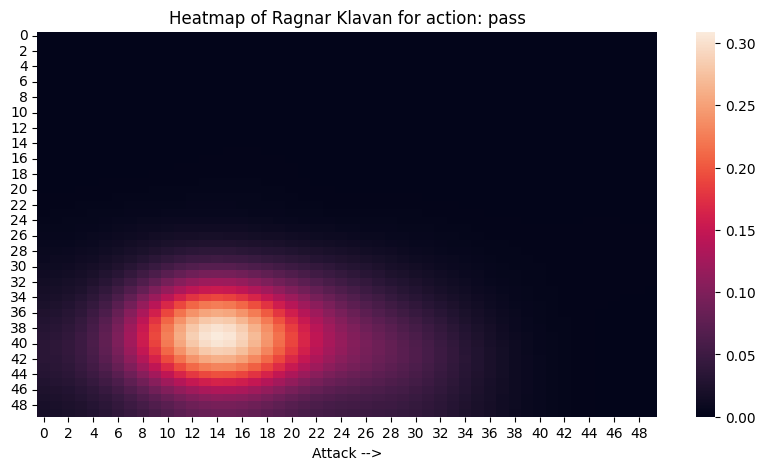

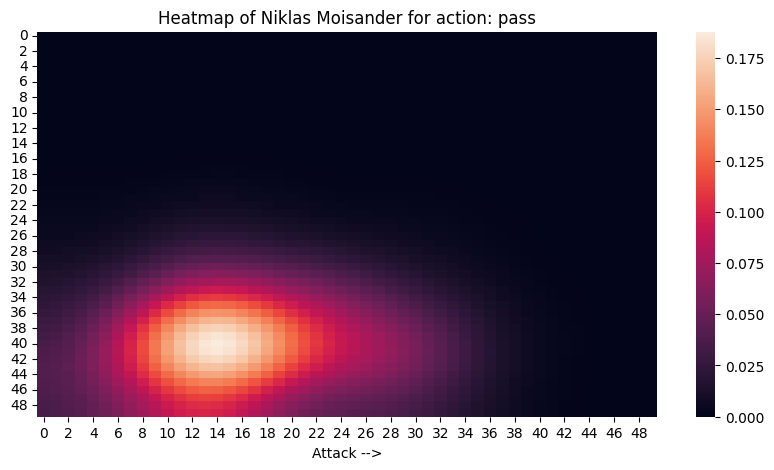

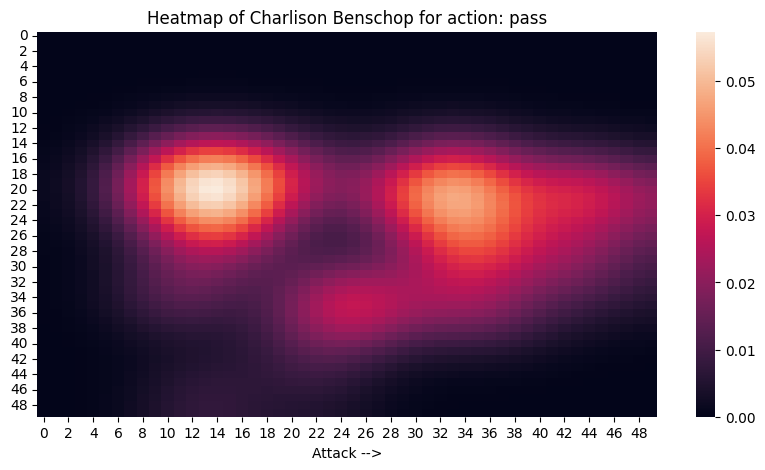

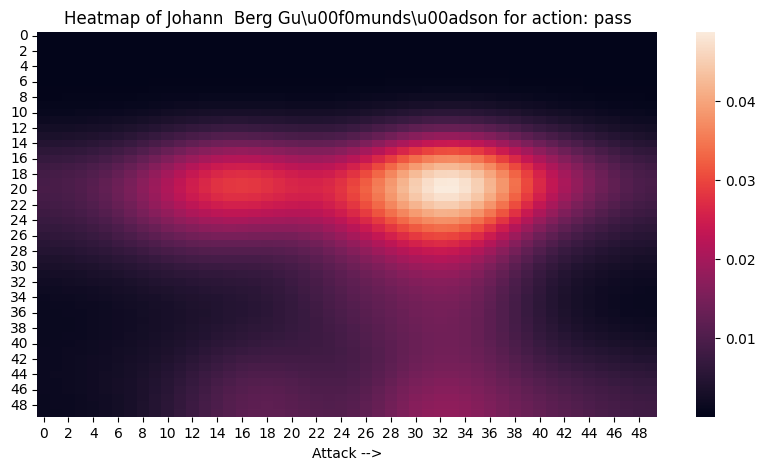

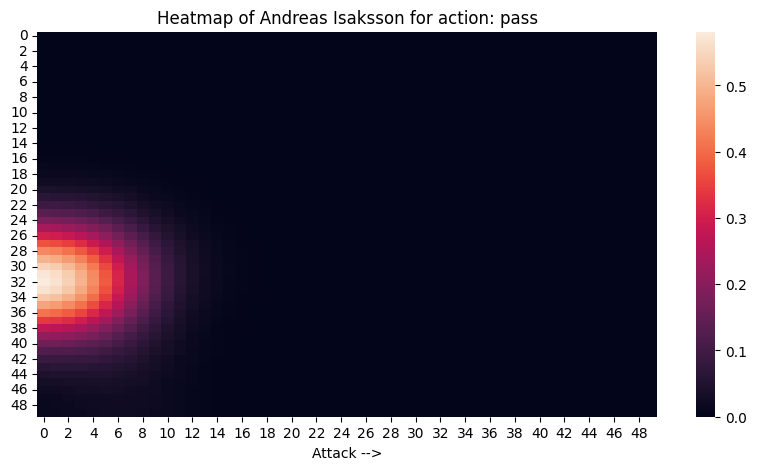

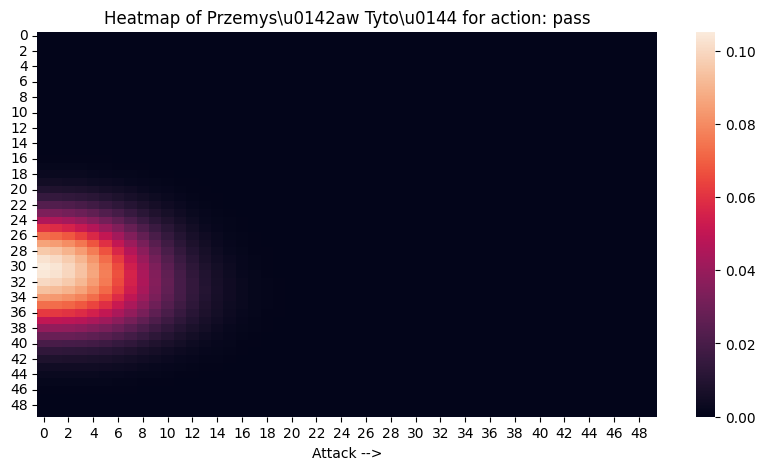

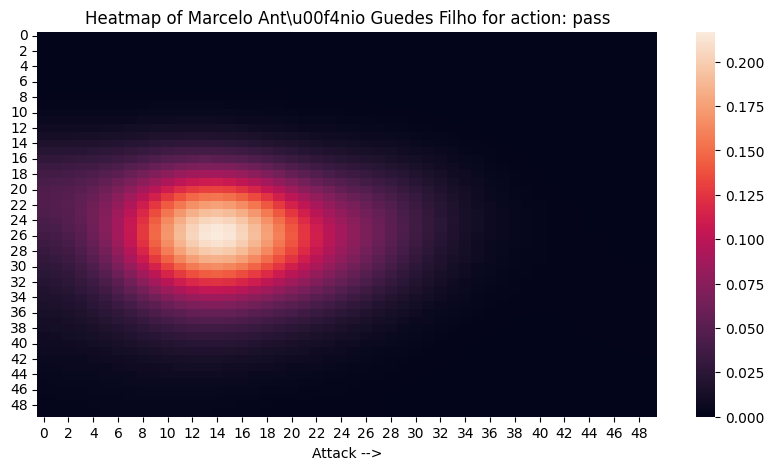

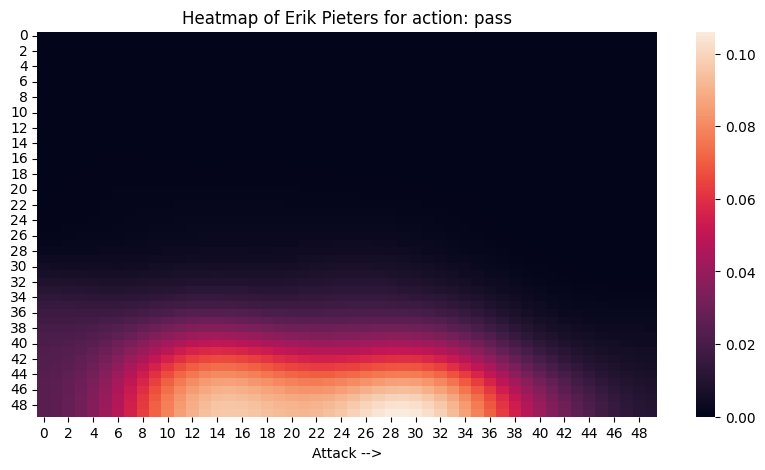

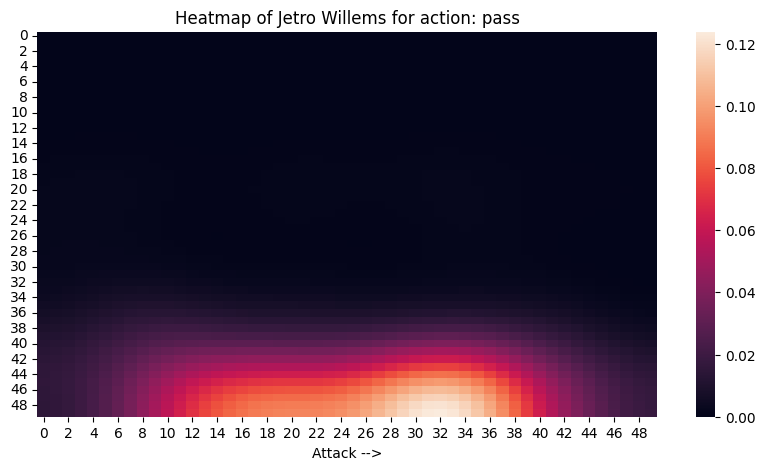

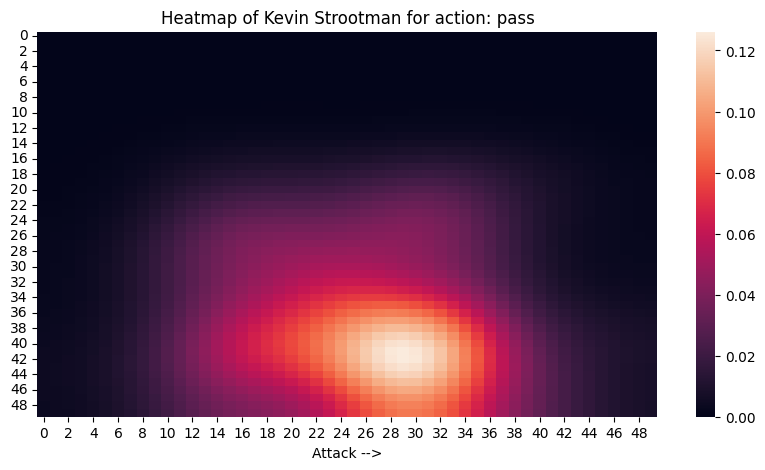

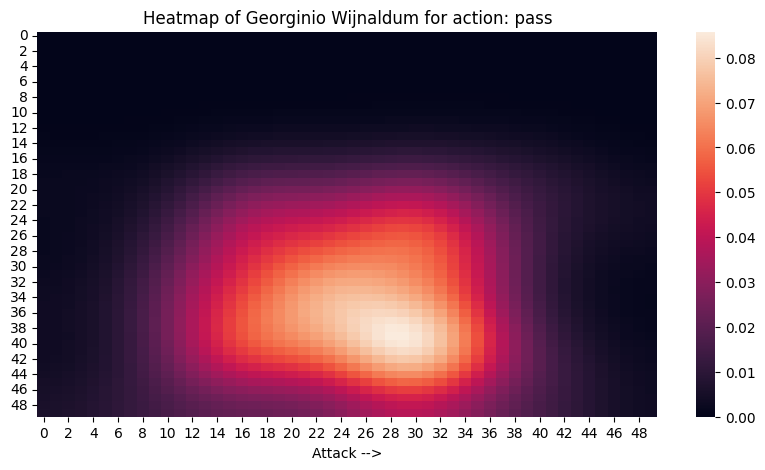

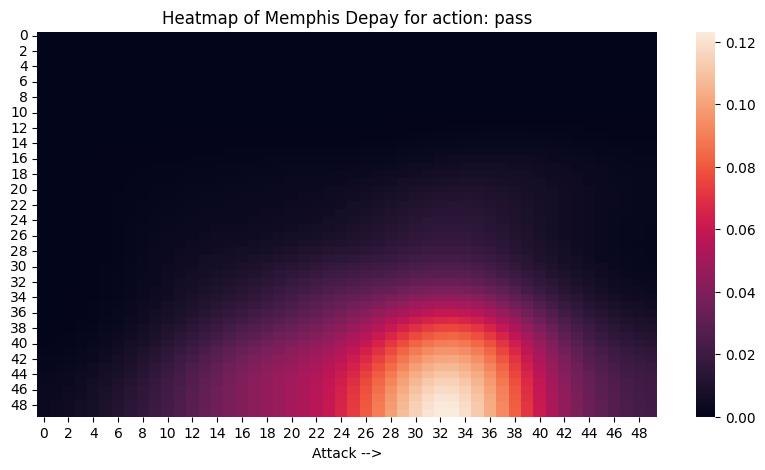

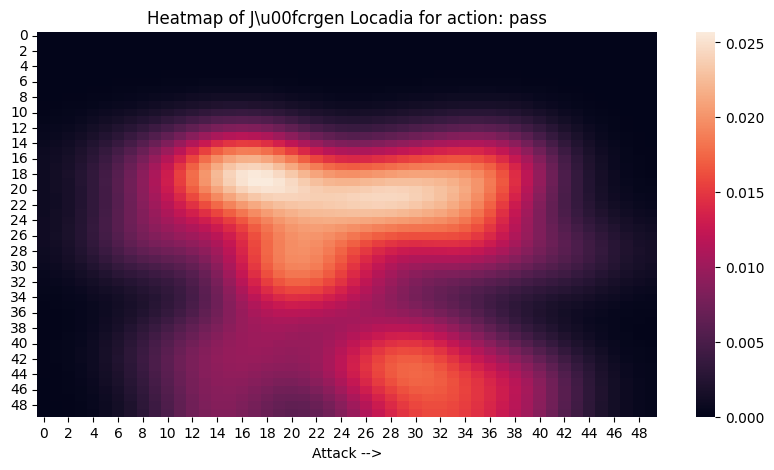

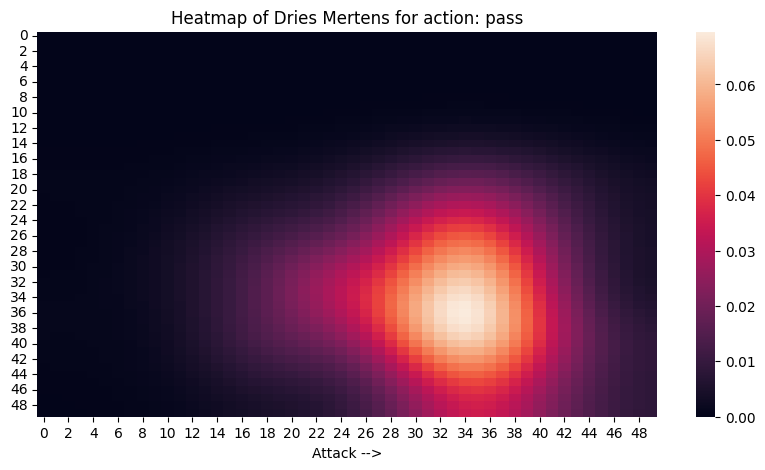

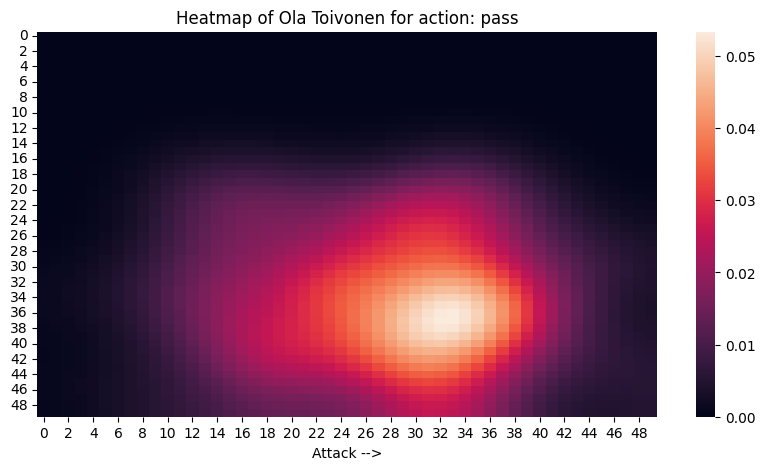

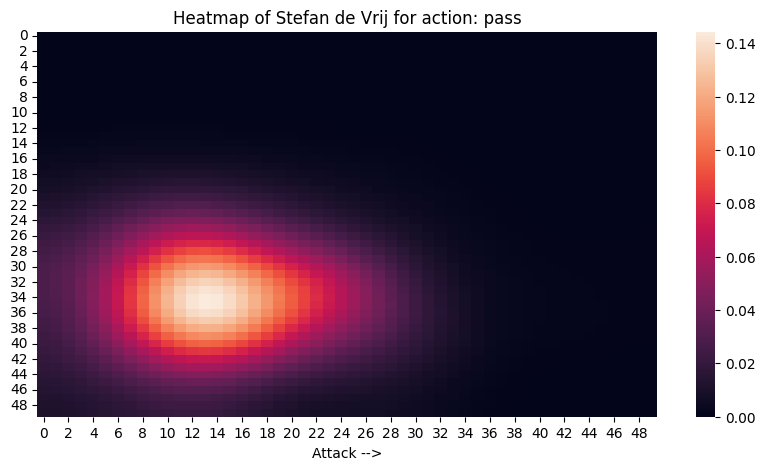

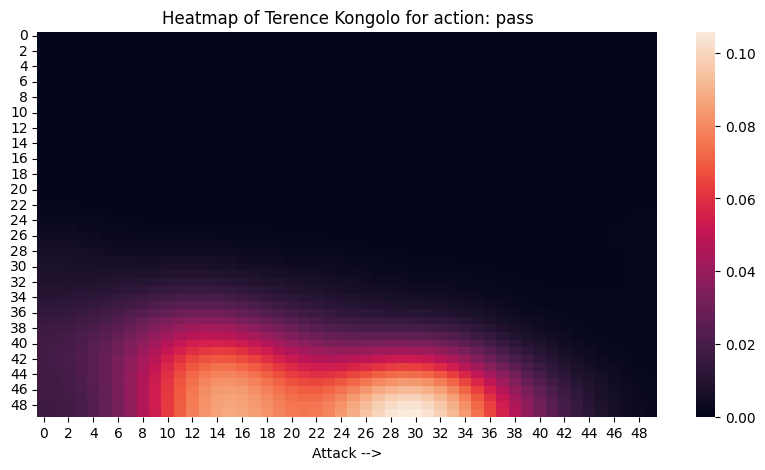

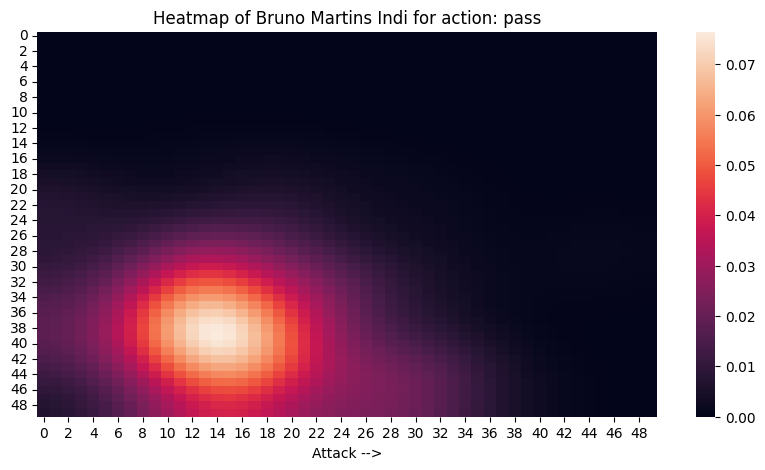

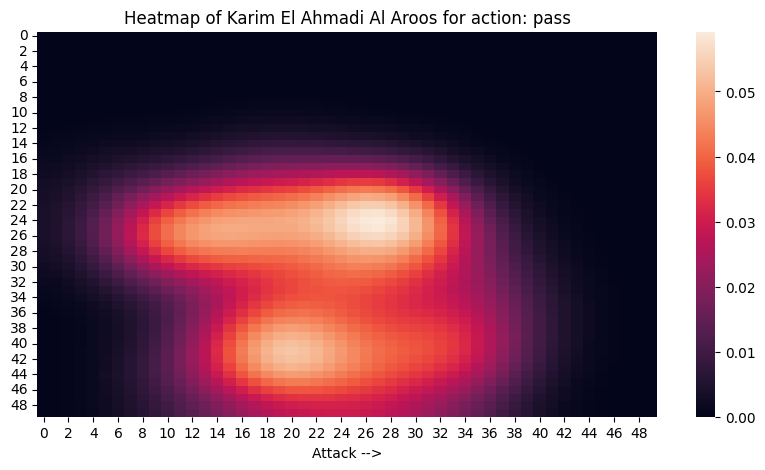

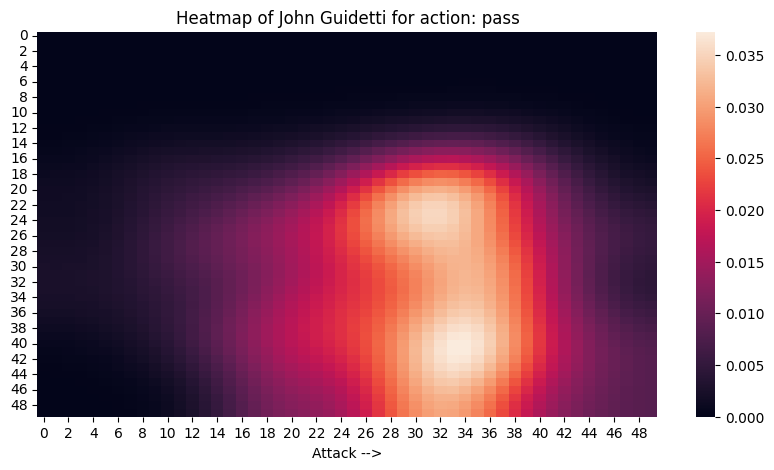

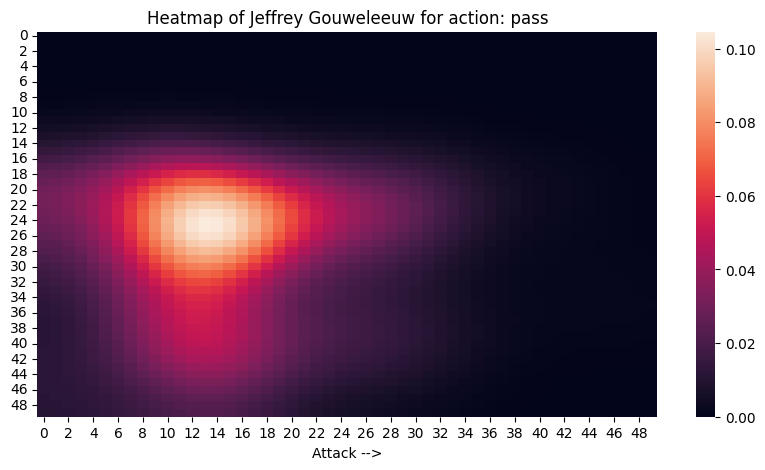

In [17]:
# Render first 30 heatmaps of random players
for i, (playerID, heatmap) in enumerate(playerID_to_heatmap.items()):
    if heatmap.player_name is not None: 
        heatmap.heatmap()
        plt.show()
    if i > 29: break